In [12]:
import pandas as pd
import numpy as np

RANDOM_STATE = 404

In [13]:
df = pd.read_csv('data/HAD.csv')
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


In [14]:
target_feature = 'MRS_90'
y = df.filter([target_feature])
y.to_csv('data/HAD_target.csv', index=False)

#### Because of the warning given while imputing missing values, 'SERUM_GLUCOSE' and 'VALV_HEART' columns are removed due to not having any other entry than '-1' value

In [15]:
df = df.drop(columns={'SERUM_GLUCOSE', 'SERUM_GLUCOSE_MISSING', 'VALV_HEART', 'MRS_90', 'MRS_90_DICHO'}, axis=1)
df.shape

(944, 37)

### Generating missing data based on sklearn imputers

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# import warnings
# warnings.filterwarnings('ignore')

imputer_df = df.copy()  # Creating a copy of the original DataFrame for imputation

# Initialize IterativeImputer with median strategy for missing values
imp = IterativeImputer(missing_values=-1, initial_strategy='median', random_state=RANDOM_STATE)

# Iterate through columns in the DataFrame
for col in imputer_df.columns:
    # Skip columns ending with '_MISSING'
    if col.endswith('_MISSING'):
        continue
    # Check if there is a corresponding missing flag column
    elif col + "_MISSING" in df.columns:
        # Check if there are missing values to impute
        if (imputer_df[col + "_MISSING"] == 1).any() and (imputer_df[col] == -1).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()
    else:
        # Check if there are missing values to impute
        if (imputer_df[col] == -1).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()

# Remove columns related to missingness flags
imputer_df = imputer_df[imputer_df.columns.drop(list(imputer_df.filter(regex='MISSING')))]

# Save the imputed DataFrame to a CSV file
imputer_df.to_csv('data/HAD_no_missingness.csv', index=False)

imputer_df.head()


,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70.0,0,3.0,148.0,0.0,0.0,1.0,1.0,0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,64.0,96.0,180.0,217.0
1,55.0,0,6.0,142.0,3.0,0.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,38.0,104.0,165.0,217.0
2,73.0,0,3.0,170.0,0.0,1.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,90.0,116.0,170.0,217.0
3,81.0,0,10.0,148.0,0.0,0.0,1.0,0.0,1,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,69.0,90.0,115.0,217.0
4,81.0,1,11.0,148.0,0.0,0.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,98.0,110.0,120.0,217.0


### Using BIC to get the optimal number of components for GMM

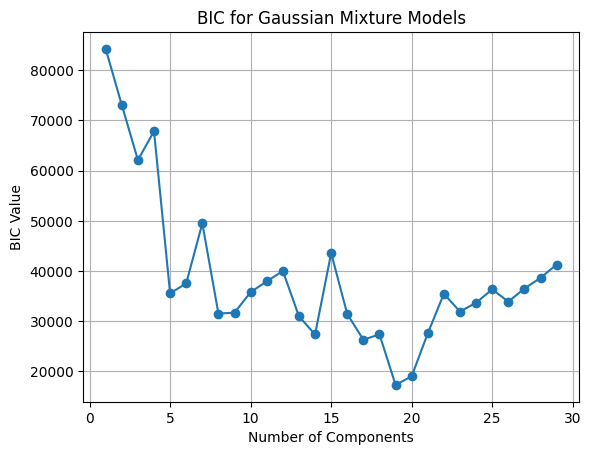

In [17]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, n_components_range):
    """
    Computes the Bayesian Information Criterion (BIC) for Gaussian Mixture Models with different numbers of components.
    
    Parameters:
        X (array-like): Input data.
        n_components_range (range): Range of number of components to evaluate.
        
    Returns:
        list: BIC values for each number of components.
    """
    bic = []  # List to store BIC values
    for n_components in n_components_range:
        # Create Gaussian Mixture Model with specified number of components
        gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
        gmm.fit(X)  # Fit the model to the data
        bic.append(gmm.bic(X))  # Calculate BIC and add to list
    return bic  # Return list of BIC values

n_components_range = range(1, 30)  # Range of number of components to evaluate

bic_values = compute_bic(imputer_df, n_components_range)  # Compute BIC values

optimal_n_components = n_components_range[np.argmin(bic_values)]  # Determine optimal number of components

# Plotting BIC values
plt.plot(n_components_range, bic_values, marker='o')  # Plot BIC values
plt.xlabel('Number of Components')  # X-axis label
plt.ylabel('BIC Value')  # Y-axis label
plt.title('BIC for Gaussian Mixture Models')  # Title of the plot
plt.grid(True)  # Show grid
plt.show()  # Show plot


### Gaussian Mixture Model fitting

In [18]:
# Create Gaussian Mixture Model with optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=RANDOM_STATE)

# Fit the Gaussian Mixture Model to the imputed DataFrame
gmm.fit(imputer_df)

GaussianMixture(n_components=19, random_state=404)

## Setting all the values of CTA_CS to -1 for the purpose of heatmap below

In [19]:
# Saving the values of CTA_CS to mark them in the heatmap
CTA_CS_original_values = pd.Series(df['CTA_CS'].copy().values, index=df.index)

df['CTA_CS'] = -1

### Imputing missing values with the help of conditional GMM

In [20]:
from ConditionalGMM.condGMM import CondGMM
import json

def gmm_generate_samples(n_datapoints=2, n_samples=1000, plot_histograms=False, print_index=False):
    """
    Generate samples using Conditional Gaussian Mixture Model for imputing missing data.

    Args:
        n_datapoints (int/str): Number of data points to consider
        n_samples (int): Number of samples to generate
        plot_histograms (bool): Whether to plot histograms of sampled data
        print_index (bool): Whether to print the index of the current data point
    Returns:
        pd.DataFrame: DataFrame with imputed missing data
    """
    if n_datapoints > df.shape[0]:
        n_datapoints = df.shape[0]

    # Create a copy of the DataFrame for data manipulation
    temp_df = df.head(n_datapoints).copy().astype(object)
    # Remove missing flag columns
    temp_df = temp_df[temp_df.columns.drop(list(temp_df.filter(regex='MISSING')))]
        
    for index, row in df.head(n_datapoints).iterrows():
        # Get indices and values of unknown and known features
        unknown_features_indexes, known_features_indexes, known_features_values = get_feature_indices_and_values(temp_df, index, row)
        
        if index = 265:
            print('error')
        
        # If all features are known, continue
        if len(unknown_features_indexes) == 0:
            continue
        
        # Initialize CondGMM
        cGMM = CondGMM(gmm.weights_, gmm.means_, gmm.covariances_, known_features_indexes)
        
        # Generate samples using Conditional GMM
        sampled_data = cGMM.rvs(known_features_values, size=n_samples, random_state=RANDOM_STATE)
        
        # Update unknown features with sampled data
        for feature_index in range(len(unknown_features_indexes)):
            temp_df.iloc[index, unknown_features_indexes[feature_index]] = json.dumps([sampled_data[sample_index][feature_index] for sample_index in range(n_samples)])

        # Plot histograms if specified
        if plot_histograms:
            plot_histogram(temp_df, unknown_features_indexes, index, sampled_data)
        
        # Print index if specified, for debugging purposes
        if print_index:
            print(index)
        
    return temp_df
        
def get_feature_indices_and_values(temp_df, index, row):    
    unknown_features_indexes = []  # Initialize list to store indices of unknown features
    
    # Iterate through columns in the DataFrame
    for col in df.columns:
        # Skip columns ending with '_MISSING'
        if col.endswith('_MISSING'):
            continue
        # Check if there is a corresponding missing flag column
        elif col + "_MISSING" in df.columns:
            # Identify unknown features where missing flag is 1 and value is -1
            if row[col + "_MISSING"] == 1 and row[col] == -1:
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        else:
            # Identify unknown features where value is -1
            if row[col] == -1:
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        
    # Find indices of known features
    known_features_indexes = list(set(range(temp_df.shape[1])) - set(unknown_features_indexes))
    
    # Extract values of known features for the given row
    known_features_values = temp_df.iloc[index, known_features_indexes]
    
    return unknown_features_indexes, known_features_indexes, known_features_values  # Return indices and values

def plot_histogram(temp_df, unknown_features_indexes, index, sampled_data, n_bins=20):
    # Create subplots based on the number of unknown features
    fig, axs = plt.subplots(sampled_data.shape[1], 1, figsize=(8, len(unknown_features_indexes) * 4))

    # Plot histograms for each feature
    plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins)

    # Add title and labels to the figure
    fig.suptitle(f'Histograms for index {index}', fontsize=20)  # Title with the index
    fig.text(0.5, 0.04, 'Value', ha='center', fontsize=14)  # X-axis label
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)  # Y-axis label
    plt.show()  # Show the figure

    
def plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins):
    # Ensure axs is a list for consistency in cases when only one feature is plotted
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for i in range(sampled_data.shape[1]):
        expected_value = imputer_df.iloc[index, unknown_features_indexes[i]]
        
        # Plot histogram for the feature
        axs[i].hist(sampled_data[:, i], bins=n_bins, alpha=0.5, label='sampled data')
        axs[i].hist(imputer_df[imputer_df.columns[unknown_features_indexes[i]]], bins=n_bins, alpha=0.2, label='marginal data')
        axs[i].set_title(f'{temp_df.columns[unknown_features_indexes[i]]}')
        
        # Add expected value as text on the histogram
        axs[i].text(0.95, 0.95, f'Expected value: {expected_value}', ha='right', va='top', transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        axs[i].legend(loc='upper left')

In [23]:
%load_ext autoreload
%autoreload 2

n_datapoints = df.shape[0]
cgmm_df = gmm_generate_samples(n_datapoints=n_datapoints, n_samples=10000, print_index=True)
cgmm_df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
25

c:\Users\pieni\Documents\GitHub\GenerativeMLForPrecisionMedicine\ConditionalGMM\condGMM.py:148: RuntimeWarning: invalid value encountered in divide
  return probs / probs.sum()


ValueError: probabilities contain NaN

### Focus on CTA_CS to see how cGMM distributes data

In [ ]:
cgmm_CTA_CS_column = cgmm_df['CTA_CS']

In [ ]:
for i, entry in enumerate(cgmm_CTA_CS_column):
    if isinstance(entry, str):
        # Deserialize the string back into an array
        float_array = json.loads(entry)
        # Replace the string entry with the deserialized array
        cgmm_CTA_CS_column[i] = float_array

In [ ]:
# Determine the number of samples based on the length of an entry with a list of values
list_length = None
for entry in cgmm_CTA_CS_column:
    if isinstance(entry, list):
        list_length = len(entry)
        break

# Define bin edges
n_bins = 13
width = 3/(n_bins-1)
h_min = 0
h_max = 3
bin_edges = np.arange(h_min - width/2, h_max +  width, width)

# Assuming cgmm_CTA_CS_column contains arrays of floats
histograms = []

for entry in cgmm_CTA_CS_column:
    if isinstance(entry, list):
        # Apply np.histogram with specified bin edges
        hist, _ = np.histogram(entry, bins=bin_edges)
        histograms.append(hist)
    else:
        # Single-value entry: Place it in the correct bin and set frequency to list_length
        hist = np.zeros(len(bin_edges) - 1)
        index = np.digitize([entry], bin_edges)[0] - 1
        if 0 <= index < len(hist):
            hist[index] = list_length
        histograms.append(hist)

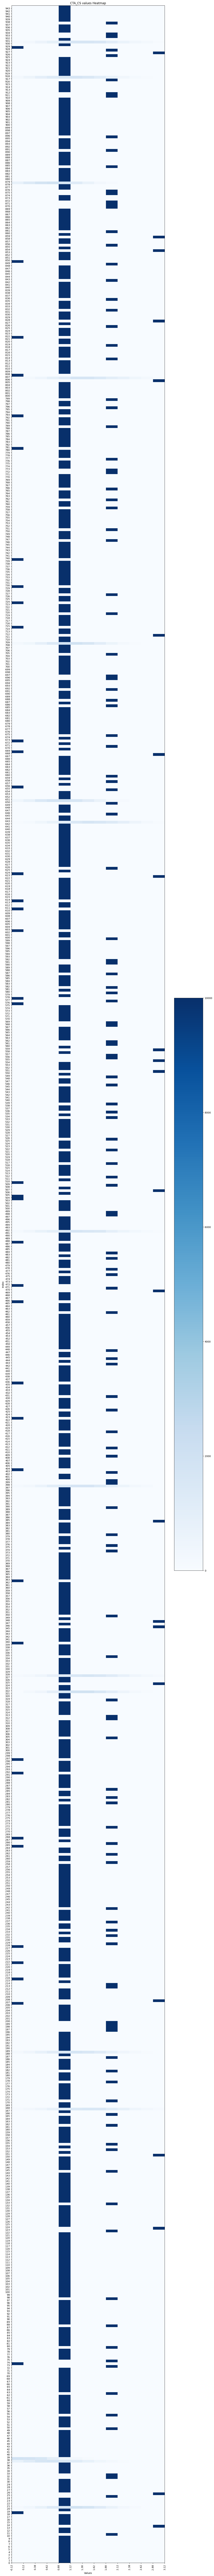

In [ ]:
# Reshape histograms to fit imshow format (histograms should be a 2D array)
histograms_2d = np.array(histograms)

# Determine figure height based on the number of datapoints
fig_height = max(6, n_datapoints * 0.2)
fig_width = min(max(10, bin_edges.shape[0] * 1), 32)

extent = [bin_edges[0], bin_edges[-1], 0, len(histograms)]

# Create heatmap
plt.figure(figsize=(fig_width, fig_height))
plt.imshow(histograms_2d, aspect='auto', cmap='Blues', extent=extent)
plt.colorbar()
plt.xticks(bin_edges, labels = np.round(bin_edges, 2), rotation=90)
plt.yticks(range(n_datapoints), range(n_datapoints))
plt.xlabel('Values')
plt.ylabel('Index')
plt.title('CTA_CS values Heatmap')
plt.savefig('images/CTA_CS_heatmap.png')
plt.show()